# COVID-19 Infection Rates and Mortality Rates by Uninsured

#### *Sources: Census Health Insurance By Sex By Age and Covid Tracking Project*

#### This notebook contains code to:
* Gather Census Health Insurance By Sex By Age
* Sort Census health dataframe by Estimate!!Total
* Combine male columns into larger groups
* Combine female columns into larger groups
* Create new dataframe of only necessary columns
* Create new dataframe with total for all columns
* Connect to the Covid Tracking Project API
* Create lists for Covid Tracking Project data and update Covid Tracking Project data with them
* Add lists to dictionary and create a dataframe from the dictionary
* Merge Covid Tracking Project data and Census Health data
* Filter Census Health to 'No'
* Sum 'No' column data
* Create new dataframe with total population and no insurance total
* Create new dataframe update numbers and calculate rates
* Calculate linear regression and create scatter plot annnotated with r, p-value, linear equation and r-squared for uninsured rates and infection rates
* Calculate linear regression and create scatter plot annnotated with r, p-value, linear equation and r-squared for uninsured rates and mortality rates.

In [33]:
import pandas as pd
from census import Census #<-- Python wrapper for census API
import requests
import os
import matplotlib.pyplot as plt
import scipy.stats as sts

# Census API Key
from config import api_key

#### Gather Census Health Insurance By Sex By Age

In [34]:
# provide the api key and the year to establish a session
c = Census(api_key, year=2018)

# Set an option to allow up to 300 characters to print in each column
pd.set_option('max_colwidth', 300)

tables = c.acs5.tables()

# The tables variable contains a list of dicts, so we can convert directly to a dataframe
table_df = pd.DataFrame(tables)

In [35]:
table_id = 'B27001'     

# Capture the variables URL from the table_df
url = table_df.loc[table_df['name']==table_id, 'variables'].values[0]

# Make the API call
response = requests.get(url).json()

# convert the response to a DataFrame
variables = pd.DataFrame(response['variables']).transpose()

print(f"Number of available variables: {len(variables)}")

table_info = variables[(variables['predicateType']=='int') & (variables['label'].str.contains("Estimate"))]   

print(f"Length of table info is {len(table_info)}")



columns_amounts = len(table_info)
table_column_names = []
table_column_labels = []
n = 10
census_data_list = []

# table_info.head()

state_data = c.acs5.get(("NAME"), 
                              {'for': 'state:*'})
census_data_base = pd.DataFrame(state_data)
census_data_base.head()

if columns_amounts > 50:
    for ind in table_info.index: 
        table_column_names.append(ind)
        table_column_labels.append(table_info.loc[ind,'label'])
                                 
    table_column_list = [table_column_names[i * n:(i + 1) * n] for i in range((len(table_column_names) + n - 1) // n )]

    for i in range(len(table_column_list)):
        table_columns = ""
        for j in range(len(table_column_list[i])):
            table_columns = table_columns + f"{table_column_list[i][j]},"
        
        column_list = table_columns[:-1]
#         print(column_list)
        census_data = c.acs5.get(("NAME", column_list), 
                              {'for': 'state:*'})
        census_B27001_part = pd.DataFrame(census_data)
        census_data_all = pd.merge(census_data_base, census_B27001_part, on=['state', 'NAME'], how="left")
        census_data_base = census_data_all

    census_B27001_HealthInsSexByAge_df = census_data_base
    for i in range(len(table_column_names)):
#         print(f'List Value: {table_column_names[i]}, Column Name: {census_B27001_HealthInsSexByAge_df.columns[i+2]}, Label Name: {table_column_labels[i]}')
        census_B27001_HealthInsSexByAge_df = census_B27001_HealthInsSexByAge_df.rename(columns = {census_B27001_HealthInsSexByAge_df.columns[i+2]: table_column_labels[i]}) 
else:
    table_columns = ""
    for ind in table_info.index:       
        table_columns = table_columns + f"{ind},"


    column_list = table_columns[:-1]
    census_data = c.acs5.get(("NAME", column_list), 
                              {'for': 'state:*'})

    for i in range(len(table_info)) : 
        for d in census_data:
            d[table_info.iloc[i, 0]] = d.pop(table_info.index[i]) 

    census_B27001_HealthInsSexByAge_df = pd.DataFrame(census_data)
    
outfile = os.path.join("Output", "census_B27001_HealthInsSexByAge.csv")
census_B27001_HealthInsSexByAge_df.to_csv(outfile, encoding="utf-8", index=False )
census_B27001_HealthInsSexByAge_df.head()

Number of available variables: 228
Length of table info is 57


,NAME,state,Estimate!!Total!!Female!!Under 6 years,Estimate!!Total!!Female!!Under 6 years!!With health insurance coverage,Estimate!!Total!!Female,Estimate!!Total!!Male!!55 to 64 years!!No health insurance coverage,Estimate!!Total!!Male!!65 to 74 years,Estimate!!Total!!Male!!55 to 64 years,Estimate!!Total!!Male!!55 to 64 years!!With health insurance coverage,Estimate!!Total!!Male!!75 years and over,...,Estimate!!Total!!Male!!19 to 25 years!!No health insurance coverage,Estimate!!Total!!Male!!26 to 34 years,Estimate!!Total!!Male!!19 to 25 years!!With health insurance coverage,Estimate!!Total!!Male!!35 to 44 years,Estimate!!Total!!Male!!35 to 44 years!!With health insurance coverage,Estimate!!Total!!Male!!26 to 34 years!!With health insurance coverage,Estimate!!Total!!Male!!26 to 34 years!!No health insurance coverage,Estimate!!Total!!Male!!45 to 54 years!!With health insurance coverage,Estimate!!Total!!Male!!35 to 44 years!!No health insurance coverage,Estimate!!Total!!Male!!45 to 54 years
0,Minnesota,27,205046.0,198639.0,2750912.0,15139.0,224335.0,362488.0,347349.0,139624.0,...,23977.0,340724.0,226635.0,342515.0,316191.0,304447.0,36277.0,340302.0,26324.0,360485.0
1,Mississippi,28,111845.0,107787.0,1523423.0,20966.0,120727.0,175972.0,155006.0,69014.0,...,40783.0,155565.0,101960.0,169912.0,132611.0,111268.0,44297.0,144748.0,37301.0,175554.0
2,Missouri,29,216826.0,205077.0,3062934.0,33694.0,257914.0,386060.0,352366.0,160452.0,...,55862.0,346029.0,227479.0,353352.0,298718.0,276054.0,69975.0,331887.0,54634.0,379468.0
3,Montana,30,35956.0,33826.0,512403.0,7998.0,54566.0,73583.0,65585.0,31737.0,...,10285.0,58578.0,39715.0,60413.0,50654.0,46234.0,12344.0,53643.0,9759.0,61952.0
4,Nebraska,31,77083.0,73807.0,943401.0,8704.0,75307.0,117342.0,108638.0,48445.0,...,14784.0,112474.0,78770.0,115502.0,99305.0,93274.0,19200.0,101505.0,16197.0,113709.0


#### Sort Census health dataframe by Estimate!!Total

In [36]:
census_B27001_HealthInsSexByAge_df.dtypes

census_HealthInsSexByAge_sorted = census_B27001_HealthInsSexByAge_df.sort_values(by=['Estimate!!Total'])
census_HealthInsSexByAge_sorted = census_HealthInsSexByAge_sorted.reset_index(drop=True)
    
census_HealthInsSexByAge_sorted.head()

,NAME,state,Estimate!!Total!!Female!!Under 6 years,Estimate!!Total!!Female!!Under 6 years!!With health insurance coverage,Estimate!!Total!!Female,Estimate!!Total!!Male!!55 to 64 years!!No health insurance coverage,Estimate!!Total!!Male!!65 to 74 years,Estimate!!Total!!Male!!55 to 64 years,Estimate!!Total!!Male!!55 to 64 years!!With health insurance coverage,Estimate!!Total!!Male!!75 years and over,...,Estimate!!Total!!Male!!19 to 25 years!!No health insurance coverage,Estimate!!Total!!Male!!26 to 34 years,Estimate!!Total!!Male!!19 to 25 years!!With health insurance coverage,Estimate!!Total!!Male!!35 to 44 years,Estimate!!Total!!Male!!35 to 44 years!!With health insurance coverage,Estimate!!Total!!Male!!26 to 34 years!!With health insurance coverage,Estimate!!Total!!Male!!26 to 34 years!!No health insurance coverage,Estimate!!Total!!Male!!45 to 54 years!!With health insurance coverage,Estimate!!Total!!Male!!35 to 44 years!!No health insurance coverage,Estimate!!Total!!Male!!45 to 54 years
0,Wyoming,56,22327.0,20663.0,281743.0,4436.0,26214.0,40268.0,35832.0,14670.0,...,5623.0,35891.0,22211.0,36098.0,29919.0,28136.0,7755.0,29014.0,6179.0,34377.0
1,Vermont,50,17323.0,17033.0,314321.0,1783.0,32709.0,46576.0,44793.0,17866.0,...,2304.0,32480.0,30278.0,34237.0,31527.0,28347.0,4133.0,39089.0,2710.0,42045.0
2,District of Columbia,11,25379.0,24939.0,357389.0,1392.0,19786.0,32288.0,30896.0,12195.0,...,2510.0,65547.0,33248.0,47693.0,44254.0,60799.0,4748.0,35116.0,3439.0,37640.0
3,Alaska,02,32039.0,28933.0,349092.0,6651.0,27405.0,48456.0,41805.0,11122.0,...,9550.0,49428.0,26553.0,44805.0,36209.0,36861.0,12567.0,38491.0,8596.0,47207.0
4,North Dakota,38,31068.0,29261.0,360097.0,3000.0,28826.0,47961.0,44961.0,19149.0,...,4908.0,53343.0,39529.0,44008.0,39537.0,46273.0,7070.0,39669.0,4471.0,43537.0


#### Combine male columns into larger groups

In [37]:
census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!18 and under years!!No'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!Under 6 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!6 to 18 years!!No health insurance coverage']
                                                                

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!19 to 44 years!!No'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!19 to 25 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!26 to 34 years!!No health insurance coverage'] +\
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!35 to 44 years!!No health insurance coverage'] 

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!45 to 64 years!!No'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!45 to 54 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!55 to 64 years!!No health insurance coverage']

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!65 and over years!!No'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!65 to 74 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!75 years and over!!No health insurance coverage'] 
                                                                

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!All Ages!!No']= census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!Under 6 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!6 to 18 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!19 to 25 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!26 to 34 years!!No health insurance coverage'] +\
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!35 to 44 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!45 to 54 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!55 to 64 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!65 to 74 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!75 years and over!!No health insurance coverage']



census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!18 and under years!!Yes'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!Under 6 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!6 to 18 years!!With health insurance coverage']
                                                                

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!19 to 44 years!!Yes'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!19 to 25 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!26 to 34 years!!With health insurance coverage'] +\
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!35 to 44 years!!With health insurance coverage'] 

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!45 to 64 years!!Yes'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!45 to 54 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!55 to 64 years!!With health insurance coverage']

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!65 and over years!!Yes'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!65 to 74 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!75 years and over!!With health insurance coverage']


census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!All Ages!!Yes'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!Under 6 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!6 to 18 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!19 to 25 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!26 to 34 years!!With health insurance coverage'] +\
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!35 to 44 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!45 to 54 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!55 to 64 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!65 to 74 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!75 years and over!!With health insurance coverage']
 

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!18 and under years'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!Under 6 years'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!6 to 18 years']
                                                                

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!19 to 44 years'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!19 to 25 years'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!26 to 34 years'] +\
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!35 to 44 years'] 

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!45 to 64 years'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!45 to 54 years'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!55 to 64 years']

census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!65 and over years'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!65 to 74 years'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Male!!75 years and over'] 



census_HealthInsSexByAge_sorted.head()

,NAME,state,Estimate!!Total!!Female!!Under 6 years,Estimate!!Total!!Female!!Under 6 years!!With health insurance coverage,Estimate!!Total!!Female,Estimate!!Total!!Male!!55 to 64 years!!No health insurance coverage,Estimate!!Total!!Male!!65 to 74 years,Estimate!!Total!!Male!!55 to 64 years,Estimate!!Total!!Male!!55 to 64 years!!With health insurance coverage,Estimate!!Total!!Male!!75 years and over,...,Estimate!!Total!!Male!!All Ages!!No,Estimate!!Total!!Male!!18 and under years!!Yes,Estimate!!Total!!Male!!19 to 44 years!!Yes,Estimate!!Total!!Male!!45 to 64 years!!Yes,Estimate!!Total!!Male!!65 and over years!!Yes,Estimate!!Total!!Male!!All Ages!!Yes,Estimate!!Total!!Male!!18 and under years,Estimate!!Total!!Male!!19 to 44 years,Estimate!!Total!!Male!!45 to 64 years,Estimate!!Total!!Male!!65 and over years
0,Wyoming,56,22327.0,20663.0,281743.0,4436.0,26214.0,40268.0,35832.0,14670.0,...,35080.0,69236.0,80266.0,64846.0,40752.0,255100.0,74828.0,99823.0,74645.0,40884.0
1,Vermont,50,17323.0,17033.0,314321.0,1783.0,32709.0,46576.0,44793.0,17866.0,...,15162.0,64893.0,90152.0,83882.0,50486.0,289413.0,66080.0,99299.0,88621.0,50575.0
2,District of Columbia,11,25379.0,24939.0,357389.0,1392.0,19786.0,32288.0,30896.0,12195.0,...,16388.0,64422.0,138301.0,66012.0,31746.0,300481.0,65962.0,148998.0,69928.0,31981.0
3,Alaska,02,32039.0,28933.0,349092.0,6651.0,27405.0,48456.0,41805.0,11122.0,...,57175.0,89843.0,99623.0,80296.0,38077.0,307839.0,100488.0,130336.0,95663.0,38527.0
4,North Dakota,38,31068.0,29261.0,360097.0,3000.0,28826.0,47961.0,44961.0,19149.0,...,30734.0,87638.0,125339.0,84630.0,47803.0,345410.0,94883.0,141788.0,91498.0,47975.0


#### Combine female columns into larger groups

In [38]:
census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!18 and under years!!No'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!Under 6 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!6 to 18 years!!No health insurance coverage']
                                                                

census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!19 to 44 years!!No'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!19 to 25 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!26 to 34 years!!No health insurance coverage'] +\
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!35 to 44 years!!No health insurance coverage'] 

census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!45 to 64 years!!No'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!45 to 54 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!55 to 64 years!!No health insurance coverage']

census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!65 and over years!!No'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!65 to 74 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!75 years and over!!No health insurance coverage'] 
                                                                

census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!All Ages!!No']= census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!Under 6 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!6 to 18 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!19 to 25 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!26 to 34 years!!No health insurance coverage'] +\
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!35 to 44 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!45 to 54 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!55 to 64 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!65 to 74 years!!No health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!75 years and over!!No health insurance coverage']








census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!18 and under years!!Yes'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!Under 6 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!6 to 18 years!!With health insurance coverage']
                                                                

census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!19 to 44 years!!Yes'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!19 to 25 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!26 to 34 years!!With health insurance coverage'] +\
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!35 to 44 years!!With health insurance coverage'] 

census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!45 to 64 years!!Yes'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!45 to 54 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!55 to 64 years!!With health insurance coverage']

census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!65 and over years!!Yes'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!65 to 74 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!75 years and over!!With health insurance coverage']


census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!All Ages!!Yes'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!Under 6 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!6 to 18 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!19 to 25 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!26 to 34 years!!With health insurance coverage'] +\
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!35 to 44 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!45 to 54 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!55 to 64 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!65 to 74 years!!With health insurance coverage'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!75 years and over!!With health insurance coverage']
 

census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!18 and under years'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!Under 6 years'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!6 to 18 years']
                                                                
census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!19 to 44 years'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!19 to 25 years'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!26 to 34 years'] +\
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!35 to 44 years'] 

census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!45 to 64 years'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!45 to 54 years'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!55 to 64 years']

census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!65 and over years'] = census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!65 to 74 years'] + \
                                                                census_HealthInsSexByAge_sorted['Estimate!!Total!!Female!!75 years and over'] 


census_HealthInsSexByAge_sorted.head()

,NAME,state,Estimate!!Total!!Female!!Under 6 years,Estimate!!Total!!Female!!Under 6 years!!With health insurance coverage,Estimate!!Total!!Female,Estimate!!Total!!Male!!55 to 64 years!!No health insurance coverage,Estimate!!Total!!Male!!65 to 74 years,Estimate!!Total!!Male!!55 to 64 years,Estimate!!Total!!Male!!55 to 64 years!!With health insurance coverage,Estimate!!Total!!Male!!75 years and over,...,Estimate!!Total!!Female!!All Ages!!No,Estimate!!Total!!Female!!18 and under years!!Yes,Estimate!!Total!!Female!!19 to 44 years!!Yes,Estimate!!Total!!Female!!45 to 64 years!!Yes,Estimate!!Total!!Female!!65 and over years!!Yes,Estimate!!Total!!Female!!All Ages!!Yes,Estimate!!Total!!Female!!18 and under years,Estimate!!Total!!Female!!19 to 44 years,Estimate!!Total!!Female!!45 to 64 years,Estimate!!Total!!Female!!65 and over years
0,Wyoming,56,22327.0,20663.0,281743.0,4436.0,26214.0,40268.0,35832.0,14670.0,...,29807.0,64614.0,78257.0,64703.0,44362.0,251936.0,70175.0,93586.0,73437.0,44545.0
1,Vermont,50,17323.0,17033.0,314321.0,1783.0,32709.0,46576.0,44793.0,17866.0,...,10200.0,60807.0,94106.0,89726.0,59482.0,304121.0,61817.0,99456.0,93453.0,59595.0
2,District of Columbia,11,25379.0,24939.0,357389.0,1392.0,19786.0,32288.0,30896.0,12195.0,...,10700.0,64547.0,163506.0,71797.0,46839.0,346689.0,65756.0,169896.0,74581.0,47156.0
3,Alaska,02,32039.0,28933.0,349092.0,6651.0,27405.0,48456.0,41805.0,11122.0,...,45781.0,84716.0,103474.0,77058.0,38063.0,303311.0,94203.0,126219.0,90104.0,38566.0
4,North Dakota,38,31068.0,29261.0,360097.0,3000.0,28826.0,47961.0,44961.0,19149.0,...,23751.0,82873.0,114799.0,82921.0,55753.0,336346.0,88918.0,127198.0,88084.0,55897.0


#### Create new dataframe of only necessary columns

In [39]:
census_HealthInsSexByAge_Combined = census_HealthInsSexByAge_sorted[['NAME', 
                                                   'state',                                                  
                                                   'Estimate!!Total!!Male!!18 and under years!!No',
                                                   'Estimate!!Total!!Male!!19 to 44 years!!No',
                                                   'Estimate!!Total!!Male!!45 to 64 years!!No',
                                                   'Estimate!!Total!!Male!!65 and over years!!No',
                                                   'Estimate!!Total!!Male!!All Ages!!No',
                                                   'Estimate!!Total!!Male!!18 and under years!!Yes',
                                                   'Estimate!!Total!!Male!!19 to 44 years!!Yes',
                                                   'Estimate!!Total!!Male!!45 to 64 years!!Yes',
                                                   'Estimate!!Total!!Male!!65 and over years!!Yes',
                                                   'Estimate!!Total!!Male!!All Ages!!Yes',
                                                   'Estimate!!Total!!Male!!18 and under years',
                                                   'Estimate!!Total!!Male!!19 to 44 years',
                                                   'Estimate!!Total!!Male!!45 to 64 years',
                                                   'Estimate!!Total!!Male!!65 and over years',
                                                   'Estimate!!Total!!Male', 
                                                   'Estimate!!Total!!Female!!18 and under years!!No',
                                                   'Estimate!!Total!!Female!!19 to 44 years!!No',
                                                   'Estimate!!Total!!Female!!45 to 64 years!!No',
                                                   'Estimate!!Total!!Female!!65 and over years!!No',
                                                   'Estimate!!Total!!Female!!All Ages!!No',                  
                                                   'Estimate!!Total!!Female!!18 and under years!!Yes',
                                                   'Estimate!!Total!!Female!!19 to 44 years!!Yes',
                                                   'Estimate!!Total!!Female!!45 to 64 years!!Yes',
                                                   'Estimate!!Total!!Female!!65 and over years!!Yes',
                                                   'Estimate!!Total!!Female!!All Ages!!Yes',
                                                   'Estimate!!Total!!Female!!18 and under years',
                                                   'Estimate!!Total!!Female!!19 to 44 years',
                                                   'Estimate!!Total!!Female!!45 to 64 years',
                                                   'Estimate!!Total!!Female!!65 and over years',
                                                   'Estimate!!Total!!Female', 
                                                   'Estimate!!Total'
                                            ]]

outfile = os.path.join("Output", "census_HealthInsSexByAge_Combined.csv")
census_HealthInsSexByAge_Combined.to_csv(outfile, encoding="utf-8", index=False )
census_HealthInsSexByAge_Combined.head()

,NAME,state,Estimate!!Total!!Male!!18 and under years!!No,Estimate!!Total!!Male!!19 to 44 years!!No,Estimate!!Total!!Male!!45 to 64 years!!No,Estimate!!Total!!Male!!65 and over years!!No,Estimate!!Total!!Male!!All Ages!!No,Estimate!!Total!!Male!!18 and under years!!Yes,Estimate!!Total!!Male!!19 to 44 years!!Yes,Estimate!!Total!!Male!!45 to 64 years!!Yes,...,Estimate!!Total!!Female!!19 to 44 years!!Yes,Estimate!!Total!!Female!!45 to 64 years!!Yes,Estimate!!Total!!Female!!65 and over years!!Yes,Estimate!!Total!!Female!!All Ages!!Yes,Estimate!!Total!!Female!!18 and under years,Estimate!!Total!!Female!!19 to 44 years,Estimate!!Total!!Female!!45 to 64 years,Estimate!!Total!!Female!!65 and over years,Estimate!!Total!!Female,Estimate!!Total
0,Wyoming,56,5592.0,19557.0,9799.0,132.0,35080.0,69236.0,80266.0,64846.0,...,78257.0,64703.0,44362.0,251936.0,70175.0,93586.0,73437.0,44545.0,281743.0,571923.0
1,Vermont,50,1187.0,9147.0,4739.0,89.0,15162.0,64893.0,90152.0,83882.0,...,94106.0,89726.0,59482.0,304121.0,61817.0,99456.0,93453.0,59595.0,314321.0,618896.0
2,District of Columbia,11,1540.0,10697.0,3916.0,235.0,16388.0,64422.0,138301.0,66012.0,...,163506.0,71797.0,46839.0,346689.0,65756.0,169896.0,74581.0,47156.0,357389.0,674258.0
3,Alaska,02,10645.0,30713.0,15367.0,450.0,57175.0,89843.0,99623.0,80296.0,...,103474.0,77058.0,38063.0,303311.0,94203.0,126219.0,90104.0,38566.0,349092.0,714106.0
4,North Dakota,38,7245.0,16449.0,6868.0,172.0,30734.0,87638.0,125339.0,84630.0,...,114799.0,82921.0,55753.0,336346.0,88918.0,127198.0,88084.0,55897.0,360097.0,736241.0


#### Create new dataframe with total for all columns

In [40]:
total_insured = census_HealthInsSexByAge_Combined[['NAME','Estimate!!Total']]
total_insured.head()

,NAME,Estimate!!Total
0,Wyoming,571923.0
1,Vermont,618896.0
2,District of Columbia,674258.0
3,Alaska,714106.0
4,North Dakota,736241.0


#### Connect to the Covid Tracking Project API

In [41]:
# Save config information.
url = "https://api.covidtracking.com/v1/states/current.json"

covid_json = requests.get(url).json()

#### Create lists for Covid Tracking Project data and update Covid Tracking Project data with them

In [42]:
states= []
fips = []
deaths= []
covid_positives = []
dates = []

indices = list(range(len(covid_json)))

for i in indices:
    states.append(covid_json[i]['state'])
    fips.append(covid_json[i]['fips'])
    dates.append(covid_json[i]['date'])
    deaths.append(covid_json[i]['death'])
    covid_positives.append(covid_json[i]['positive'])

#### Add lists to dictionary and create a dataframe from the dictionary

In [43]:
AllStates_dict = {
    "States": states,
    "FIPS": fips,
    "Date": dates,
    "Covid Positive": covid_positives,
    "Deaths": deaths
}
AllStates_df = pd.DataFrame(AllStates_dict )
AllStates_df.head()

,States,FIPS,Date,Covid Positive,Deaths
0,AK,02,20200921,7838,45
1,AL,01,20200921,145780,2439
2,AR,05,20200921,76364,1197
3,AS,60,20200921,0,0
4,AZ,04,20200921,214251,5478


#### Merge Covid Tracking Project data and Census Health data

In [44]:
HealthIns_covid_data = pd.merge(census_HealthInsSexByAge_Combined, AllStates_df, how="outer", left_on='state', right_on='FIPS')
HealthIns_covid_data_clean = HealthIns_covid_data.dropna(axis=0, how='any')
HealthIns_covid_data_clean.head()

,NAME,state,Estimate!!Total!!Male!!18 and under years!!No,Estimate!!Total!!Male!!19 to 44 years!!No,Estimate!!Total!!Male!!45 to 64 years!!No,Estimate!!Total!!Male!!65 and over years!!No,Estimate!!Total!!Male!!All Ages!!No,Estimate!!Total!!Male!!18 and under years!!Yes,Estimate!!Total!!Male!!19 to 44 years!!Yes,Estimate!!Total!!Male!!45 to 64 years!!Yes,...,Estimate!!Total!!Female!!19 to 44 years,Estimate!!Total!!Female!!45 to 64 years,Estimate!!Total!!Female!!65 and over years,Estimate!!Total!!Female,Estimate!!Total,States,FIPS,Date,Covid Positive,Deaths
0,Wyoming,56,5592.0,19557.0,9799.0,132.0,35080.0,69236.0,80266.0,64846.0,...,93586.0,73437.0,44545.0,281743.0,571923.0,WY,56,20200921,4944,49
1,Vermont,50,1187.0,9147.0,4739.0,89.0,15162.0,64893.0,90152.0,83882.0,...,99456.0,93453.0,59595.0,314321.0,618896.0,VT,50,20200921,1719,58
2,District of Columbia,11,1540.0,10697.0,3916.0,235.0,16388.0,64422.0,138301.0,66012.0,...,169896.0,74581.0,47156.0,357389.0,674258.0,DC,11,20200921,14978,621
3,Alaska,02,10645.0,30713.0,15367.0,450.0,57175.0,89843.0,99623.0,80296.0,...,126219.0,90104.0,38566.0,349092.0,714106.0,AK,02,20200921,7838,45
4,North Dakota,38,7245.0,16449.0,6868.0,172.0,30734.0,87638.0,125339.0,84630.0,...,127198.0,88084.0,55897.0,360097.0,736241.0,ND,38,20200921,18244,151


## Infection/Death Rates

#### Filter Census Health to 'No'
#### Sum 'No' column data
#### Create new dataframe with total population and no insurance total

In [45]:
# Create boolean for people with no insurance
no_insurance_col = census_HealthInsSexByAge_sorted.columns[
    census_HealthInsSexByAge_sorted.columns.str.contains('No')
]
# Filter columns that have people with no insurance
no_insurance = census_HealthInsSexByAge_sorted[no_insurance_col]
# Add total no insurance
total_no_insurance = no_insurance.sum(axis=1)

uninsurance_rate = census_HealthInsSexByAge_sorted.iloc[:,0:2]
uninsurance_rate['uninsured'] = total_no_insurance
uninsurance_rate['total_population'] = census_HealthInsSexByAge_sorted[
    ['Estimate!!Total!!Female', 'Estimate!!Total!!Male']
].sum(axis=1)


# take away all 0's (to get rid of 01,02,03....)
uninsurance_rate['state'] = uninsurance_rate.state.str.replace('0','')
# convert to integers
uninsurance_rate['state'] = uninsurance_rate.state.astype(int)

# Fix state numbers because we replaced all 0's with nothing
uninsurance_rate.loc[6,'state'] = 10 # Delaware 1 to 10
uninsurance_rate.loc[7,'state'] = 30 # Montana 3 to 30
uninsurance_rate.loc[16,'state'] = 20 # Kansas 2 to 20
uninsurance_rate.loc[24,'state'] = 40 # Oklahoma 4 to 40
uninsurance_rate.loc[1,'state'] = 50 # Vermont 5 to 50

# sort values and set index
uninsurance_rate = uninsurance_rate.sort_values('state').set_index('state')
uninsurance_rate.head()

,NAME,uninsured,total_population
state,,,
1,Alabama,1432422.0,4785040.0
2,Alaska,308868.0,714106.0
4,Arizona,2244918.0,6838270.0
5,Arkansas,796302.0,2937135.0
6,California,9840501.0,38653948.0


#### Create new dataframe update numbers and calculate rates

In [46]:
covidinsurance_df = HealthIns_covid_data_clean[
    ['NAME', 'state', 'Estimate!!Total', 'States','FIPS','Covid Positive','Deaths']
].sort_values('state')

# take away all 0's (to get rid of 01,02,03....)
covidinsurance_df['state'] = covidinsurance_df.state.str.replace('0','')
# convert to integers
covidinsurance_df['state'] = covidinsurance_df.state.astype(int)

# Fix state numbers because we replaced all 0's with nothing
covidinsurance_df.loc[6,'state'] = 10 # Delaware 1 to 10
covidinsurance_df.loc[7,'state'] = 30 # Montana 3 to 30
covidinsurance_df.loc[16,'state'] = 20 # Kansas 2 to 20
covidinsurance_df.loc[24,'state'] = 40 # Oklahoma 4 to 40
covidinsurance_df.loc[1,'state'] = 50 # Vermont 5 to 50

covidinsurance_df.set_index('state', inplace=True)

covidinsurance_df['uninsured'] = uninsurance_rate['uninsured']
covidinsurance_df['infection_rates'] = round(
    (covidinsurance_df['Covid Positive']/covidinsurance_df['Estimate!!Total']*100),
    3)
covidinsurance_df['uninsured_rates'] = round(
    (covidinsurance_df.uninsured/covidinsurance_df['Estimate!!Total']*100),
    3)
covidinsurance_df['mortality_rates'] = round(
    (covidinsurance_df.Deaths/covidinsurance_df['Estimate!!Total']*100),
    3)

covidinsurance_df.head()

,NAME,Estimate!!Total,States,FIPS,Covid Positive,Deaths,uninsured,infection_rates,uninsured_rates,mortality_rates
state,,,,,,,,,,
1,Alabama,4785040.0,AL,01,145780,2439,1432422.0,3.047,29.935,0.051
2,Alaska,714106.0,AK,02,7838,45,308868.0,1.098,43.252,0.006
4,Arizona,6838270.0,AZ,04,214251,5478,2244918.0,3.133,32.829,0.080
5,Arkansas,2937135.0,AR,05,76364,1197,796302.0,2.600,27.112,0.041
6,California,38653948.0,CA,06,781694,15018,9840501.0,2.022,25.458,0.039


#### Calculate linear regression and create scatter plot annnotated with r, p-value, linear equation and r-squared for uninsured rates and infection rates.

The line of best fit: y = 0.04x + 0.99
The r-squared is: 0.1756103345368905


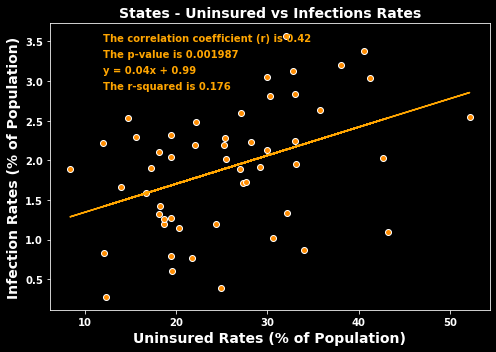

In [47]:
x_values = covidinsurance_df['uninsured_rates']
y_values = covidinsurance_df['infection_rates']

# Run the regression and store each of the returned values
(slope, intercept, rvalue, pvalue, stderr) = sts.linregress(x_values, y_values)

# Calculate the predictions for each value of x (blood pressure)
regress_values = x_values * slope + intercept

# Create the linear equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"The line of best fit: {line_eq}")


color = 'orange'

plt.style.use('dark_background')
plt.figure(figsize=(7,5))

# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="darkorange", edgecolors="white")

# Plot the regression line
plt.plot(x_values, regress_values, color)

# Add the linear equation to the plot

plt.annotate(f"The correlation coefficient (r) is {round(rvalue,2)}", (12, 3.5), fontsize=10, weight='bold', color=color)
plt.annotate(f"The p-value is {round(pvalue, 6)}", (12, 3.3), fontsize=10, weight='bold', color=color)
plt.annotate(line_eq, (12, 3.1), fontsize=10, weight='bold', color=color)
plt.annotate(f"The r-squared is {round(rvalue**2,3)}", (12, 2.9), fontsize=10, weight='bold', color=color)

# Add labels
plt.title('States - Uninsured vs Infections Rates', fontsize=14, weight='bold')
plt.xlabel('Uninsured Rates (% of Population)', fontsize=14, weight='bold')
plt.ylabel('Infection Rates (% of Population)', fontsize=14, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

# calculate r2
print(f"The r-squared is: {rvalue**2}")

plt.tight_layout()
outfile = os.path.join("Output", 'Covid19_UninsuredVInfection_Transparent.png')
plt.savefig(outfile, transparent=True)


plt.show()

#### Calculate linear regression and create scatter plot annnotated with r, p-value, linear equation and r-squared for uninsured rates and mortality rates.

The line of best fit: y = -0.0x + 0.06
The r-squared is: 0.01463371316812104


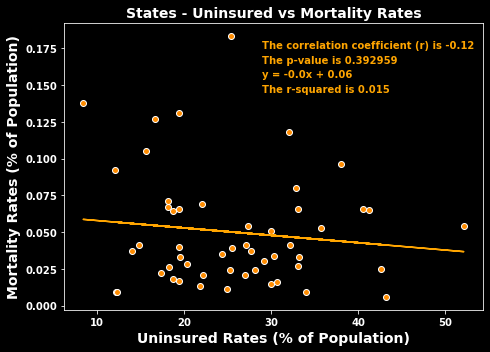

In [48]:

x_values = covidinsurance_df['uninsured_rates']
y_values = covidinsurance_df['mortality_rates']

# Run the regression and store each of the returned values
(slope, intercept, rvalue, pvalue, stderr) = sts.linregress(x_values, y_values)

# Calculate the predictions for each value of x (blood pressure)
regress_values = x_values * slope + intercept

# Create the linear equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print(f"The line of best fit: {line_eq}")

color = 'orange'


plt.figure(figsize=(7,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="darkorange", edgecolors="white")

# Plot the regression line
plt.plot(x_values, regress_values, color)

# Add the linear equation to the plot

plt.annotate(f"The correlation coefficient (r) is {round(rvalue,2)}", (29, .175), fontsize=10, weight='bold', color=color)
plt.annotate(f"The p-value is {round(pvalue, 6)}", (29, .165), fontsize=10, weight='bold', color=color)
plt.annotate(line_eq, (29, .155), fontsize=10, weight='bold', color=color)
plt.annotate(f"The r-squared is {round(rvalue**2,3)}", (29, .145), fontsize=10, weight='bold', color=color)

# Add labels
plt.xlabel('Uninsured Rates (% of Population)', fontsize=14, weight='bold')
plt.ylabel('Mortality Rates (% of Population)', fontsize=14, weight='bold')
plt.title('States - Uninsured vs Mortality Rates', fontsize=14, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')

plt.tight_layout()
outfile = os.path.join("Output", 'Covid19_UninsuredVMortality.png')
plt.savefig(outfile, transparent=True)


# calculate r2
print(f"The r-squared is: {rvalue**2}")
plt.show()
